In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique #, unionize
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss#get_loocv_predictions,get_loss#get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_indices_2ormore

# from mcmodels.core.utils import get_regionalized_normalized_data
# from mcmodels.core.utils import get_connectivity
# from mcmodels.core.utils import get_ontological_order_leaf
# from mcmodels.core.utils import get_nw_loocv,get_wt_inds
# from mcmodels.core.utils import get_countvec
# from mcmodels.core.utils import get_injection_hemisphere_id
# from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
# from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
# wt_conn = pd.read_csv('/Users/samsonkoelle/Downloads/connectivity_cre_shared/wt_conn.csv', index_col=0)
# Cux2_conn = pd.read_csv('/Users/samsonkoelle/Cux2_conn.csv', index_col=0)
# Ntsr1_conn =pd.read_csv('/Users/samsonkoelle/Ntsr1_conn.csv', index_col=0)
# Rbp4_conn = pd.read_csv('/Users/samsonkoelle/Rbp4_conn.csv', index_col=0)
# Tlx3_conn = pd.read_csv('/Users/samsonkoelle/Tlx3_conn.csv', index_col=0)

In [20]:
wt_conn = pd.read_csv('/Users/samsonkoelle/wt_conn2', index_col=0)
Cux2_conn = pd.read_csv('/Users/samsonkoelle/Cux2_conn2.csv', index_col=0)
Ntsr1_conn =pd.read_csv('/Users/samsonkoelle/Ntsr1_conn2.csv', index_col=0)
Rbp4_conn = pd.read_csv('/Users/samsonkoelle/Rbp4_conn2.csv', index_col=0)
Tlx3_conn = pd.read_csv('/Users/samsonkoelle/Tlx3_conn2.csv', index_col=0)

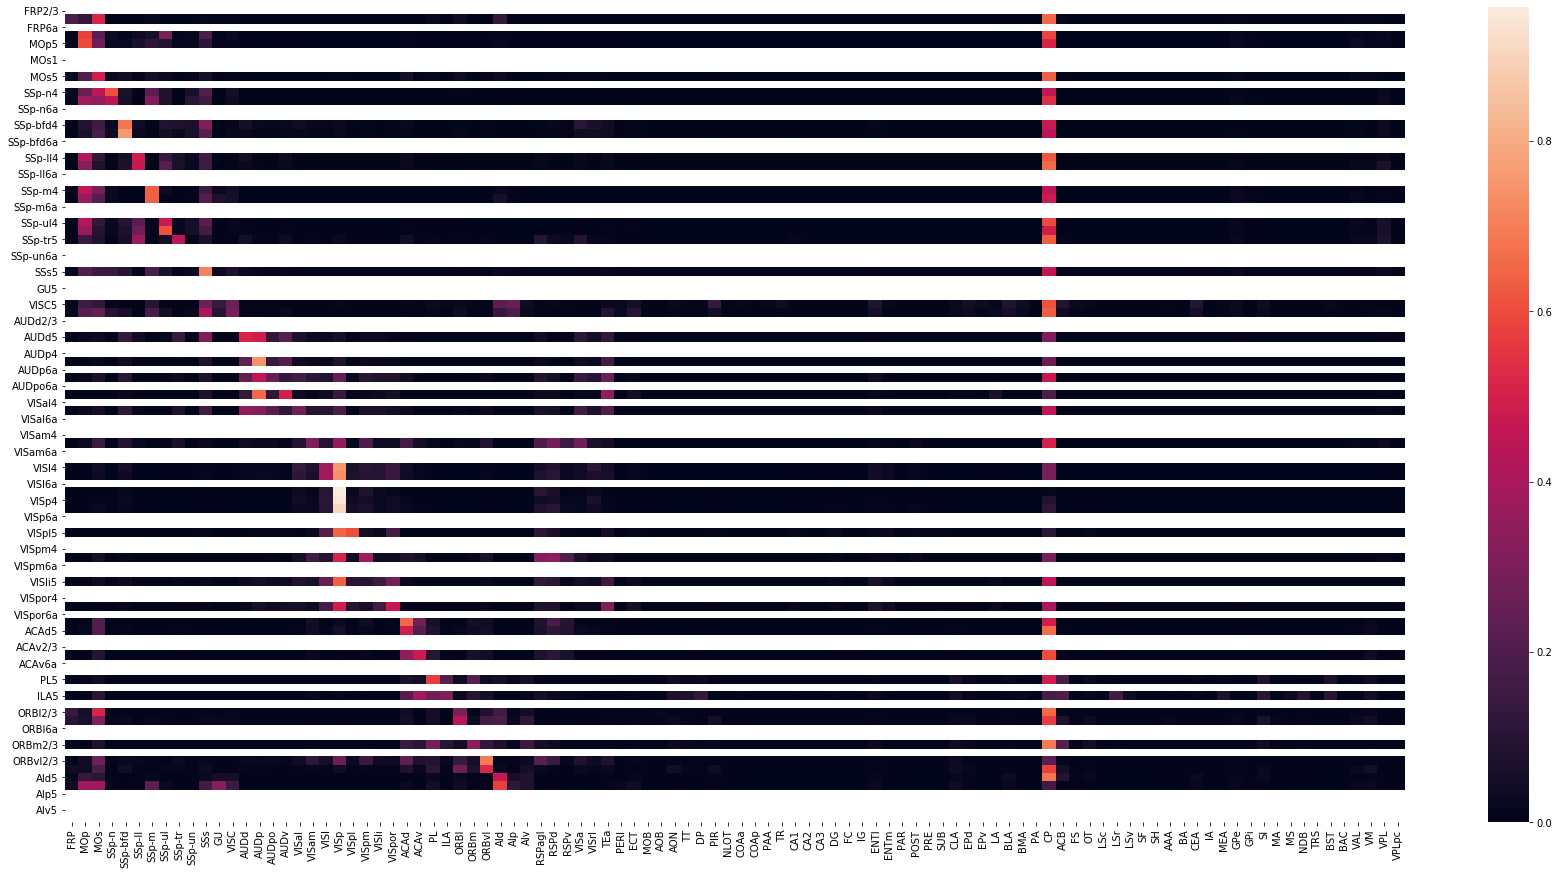

In [6]:
plt.subplots(figsize = (30,15))
sns.heatmap(wt_conn.iloc[:100, 0:100])

In [7]:
# plt.subplots(figsize = (30,15))
# sns.heatmap(wt_conn.iloc[50:100, 0:100])

In [12]:
wt_conn.loc['VISp2/3', 'VISp']#.argsort()[10:]

0.9575754189633048

In [13]:
#wt_conn.loc['VISp2/3','TMv']

In [14]:
connectivity_data = get_connectivity_data(cache, major_structure_ids[:1], experiments_exclude, remove_injection = False)

connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs

512


In [15]:
#major division segregation is legacy code but convenient for fast cross validation in major division model
#experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)
#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
#get average intensities of projection structures given ipsi and contra keys
#source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)

target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])

In [17]:
# list_2 = contra_target_regions
# list_1 = ontological_order
# set_2 = frozenset(list_2)
# contra_reorder = [x for x in list_1 if x in set_2]
# col_ids = np.concatenate([ontological_order,contra_reorder])
# col_names = np.asarray([ia_map[col_ids[i]] for i in range(len(col_ids))])




In [18]:

# for i in range(286):
#     col_names[291:][i] = col_names[291:][i]+ '.1'

# wt_conn.columns = col_names

# Cux2_conn.columns = col_names
# Ntsr1_conn.columns = col_names
# Rbp4_conn.columns = col_names
# Tlx3_conn.columns = col_names

#MOv, MOs, MOp
#np.asarray(wt_conn.columns)
source_regions = np.asarray(['VISp2/3', 'VISp4', 'VISp5', 'VISp6a','VISl4', 'VISl5', 'VISl6a'])
target_regions = np.asarray(['LGv','LGd','VISp','VISl'])
#targ_reg = np.asarray(['ORBvl','AId','AIv','PTLp','TEa','ECT','BLAa','CEA', 'ORBvl.1','AId.1','AIv.1','PTLp.1','TEa.1','ECT.1','BLAa.1','CEA.1' ])
#source_reg = np.asarray(['MOp2/3', 'MOp5', 'MOp6a','MOs2/3', 'MOs5', 'MOs6a' ])
targ_reg = np.asarray(['ORBvl','AId','AIv','TEa','ECT','BLA','CEA', 'ORBvl.1','AId.1','AIv.1','TEa.1','ECT.1','BLA.1','CEA.1' ])
source_reg = np.asarray(['MOp2/3', 'MOp5', 'MOp6a','MOs2/3', 'MOs5', 'MOs6a' ])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


[Text(0, 0.5, 'MOp2/3'),
 Text(0, 1.5, 'MOp5'),
 Text(0, 2.5, 'MOp6a'),
 Text(0, 3.5, 'MOs2/3'),
 Text(0, 4.5, 'MOs5'),
 Text(0, 5.5, 'MOs6a')]

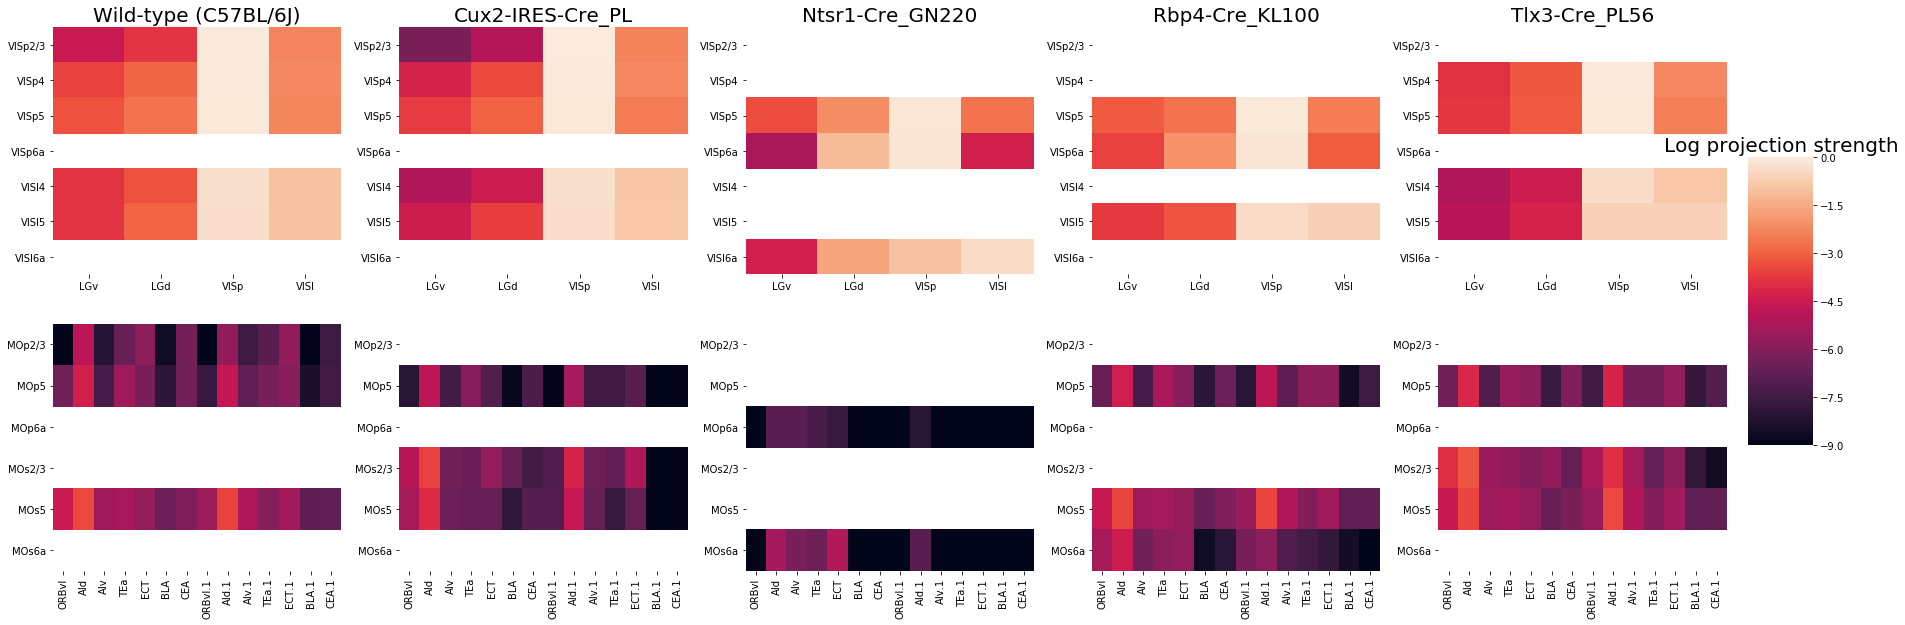

In [21]:
fig, axes = plt.subplots(2,5, figsize = (30,10))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

tp = np.log(wt_conn.loc[source_regions].loc[:,target_regions])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[0,0], cbar = False)

tp = np.log(wt_conn.loc[source_reg].loc[:,targ_reg])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[1,0], cbar = False)

tp = np.log(Cux2_conn.loc[source_regions].loc[:,target_regions])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[0,1], cbar = False)

tp = np.log(Cux2_conn.loc[source_reg].loc[:,targ_reg])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[1,1], cbar = False)

tp = np.log(Ntsr1_conn.loc[source_regions].loc[:,target_regions])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[0,2], cbar = False)

tp = np.log(Ntsr1_conn.loc[source_reg].loc[:,targ_reg])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[1,2], cbar = False)

tp = np.log(Rbp4_conn.loc[source_regions].loc[:,target_regions])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[0,3], cbar = False)

tp = np.log(Rbp4_conn.loc[source_reg].loc[:,targ_reg])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[1,3], cbar = False)

tp = np.log(Tlx3_conn.loc[source_regions].loc[:,target_regions])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[0,4], cbar = False)

tp = np.log(Tlx3_conn.loc[source_reg].loc[:,targ_reg])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[1,4], cbar = True,cbar_ax= cbar_ax) #cbar_kws={'label': 'Log projection strength'})
cbar_ax.set_title('Log projection strength', fontsize = 20)

axes[0,0].set_title('Wild-type (C57BL/6J)', fontsize = 20)
axes[0,1].set_title('Cux2-IRES-Cre_PL', fontsize = 20)
axes[0,2].set_title('Ntsr1-Cre_GN220', fontsize = 20)
axes[0,3].set_title('Rbp4-Cre_KL100', fontsize = 20)
axes[0,4].set_title('Tlx3-Cre_PL56', fontsize = 20)

axes[1,0].set_yticklabels(axes[1,0].get_yticklabels(), rotation=0)
axes[1,1].set_yticklabels(axes[1,0].get_yticklabels(), rotation=0)
axes[1,2].set_yticklabels(axes[1,0].get_yticklabels(), rotation=0)
axes[1,3].set_yticklabels(axes[1,0].get_yticklabels(), rotation=0)
axes[1,4].set_yticklabels(axes[1,0].get_yticklabels(), rotation=0)

#plt.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/visp_mo')


In [22]:
# wt_conn.to_csv('/Users/samsonkoelle/wt_conn2.csv')
# Cux2_conn.to_csv('/Users/samsonkoelle/Cux2_conn2.csv')
# Ntsr1_conn.to_csv('/Users/samsonkoelle/Ntsr1_conn2.csv')
# Rbp4_conn.to_csv('/Users/samsonkoelle/Rbp4_conn2.csv')
# Tlx3_conn.to_csv('/Users/samsonkoelle/Tlx3_conn2.csv')

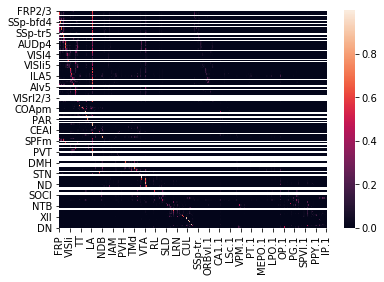

In [23]:
sns.heatmap(wt_conn)

In [24]:
comb_data = pd.concat([wt_conn,Cux2_conn,Ntsr1_conn,Rbp4_conn,Tlx3_conn])

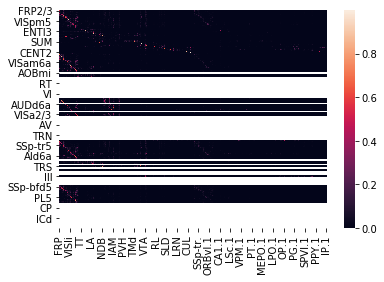

In [65]:
sns.heatmap(comb_data)

In [25]:
#sns.clustermap(wt_conn)

In [26]:
gis  = np.where(np.sum(comb_data, axis = 1) !=0.)[0]

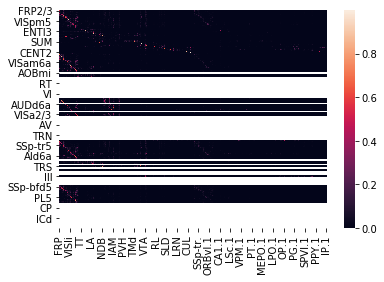

In [27]:
sns.heatmap(comb_data)

In [28]:
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs
connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)
connectivity_data.get_creleaf_combos()
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)

In [29]:
colnames = wt_conn.columns[:291]

In [30]:
sid = 512
data_merged = pd.DataFrame(np.hstack([np.expand_dims(connectivity_data.creline[sid],1),connectivity_data.structure_datas[sid].reg_proj_vcount_norm[:,:291]]), columns = np.append(['cre'],colnames))
data_melted = pd.melt(data_merged, id_vars='cre')

In [31]:
    data_melted = data_melted.astype({'value': np.float64})
    means = data_melted.groupby(by=['variable', 'cre'])['value'].mean().reset_index()
    means_cast = pd.pivot_table(means, index = 'cre', columns = 'variable')
    #means_cast.columns = means_cast.columns.get_level_values(1)
    #means_cast.index = means_cast.index.get_level_values(1)
    #sns.boxplot(x = creline[sid][es[sid]], y = ls[sid][gs[m,0]], ax=ax, order = order)

In [33]:
#means_cast

In [34]:
output = np.empty(len(ontological_order), dtype = object)
for i in range(len(ontological_order)):
    output[ i] = ia_map[np.intersect1d(st.ancestor_ids([ontological_order[i]]), major_structure_ids)[0]]
major_ontoloogy = output

In [35]:
connectivity_data.get_leaf_major_dictionary()
connectivity_data.get_major_leaf_dictionary()


In [36]:
means_cast.columns.shape

(291,)

In [37]:
major_ontoloogy

array(['Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'OLF', 'OLF', 'OLF', 'OLF',
       'OLF', 'OLF', 'OLF', 'OLF', 'OLF', 'OLF', 'OLF', 'HPF', 'HPF',
       'HPF', 'HPF', 'HPF', 'HPF', 'HPF', 'HPF', 'HPF', 'HPF', 'HPF',
       'HPF', 'CTXsp', 'CTXsp', 'CTXsp', 'CTXsp', 'CTXsp', 'CTXsp',
       'CTXsp', 'STR', 'STR', 'STR', 'STR', 'STR', 'STR', 'STR', 'STR',
       'STR', 'STR', 'STR', 'STR', 'STR', 'STR', 'PAL', 'PAL', 'PAL',


In [38]:
#networks = sns.load_dataset("brain_networks", index_col=0, header=[0, 1, 2])

major_pal = sns.cubehelix_palette(np.unique(major_ontoloogy).size,
                                    light=.9, dark=.1, reverse=True,
                                    start=1, rot=-2)
major_lut = dict(zip(map(str, np.unique(major_ontoloogy)), major_pal))

major_colors = pd.Series(major_ontoloogy).map(major_lut)

major_colors.index = means_cast.columns

In [39]:
major_colors

       variable
value  AAA         [0.3541287866313081, 0.4449149035191662, 0.212...
       ACAd        [0.3541287866313081, 0.4449149035191662, 0.212...
       ACAv        [0.3541287866313081, 0.4449149035191662, 0.212...
       ACB         [0.3541287866313081, 0.4449149035191662, 0.212...
       ACVII       [0.3541287866313081, 0.4449149035191662, 0.212...
                                         ...                        
       VTN         [0.14250609166695374, 0.06696404307500585, 0.1...
       XII         [0.14250609166695374, 0.06696404307500585, 0.1...
       ZI          [0.14250609166695374, 0.06696404307500585, 0.1...
       x           [0.14250609166695374, 0.06696404307500585, 0.1...
       y           [0.14250609166695374, 0.06696404307500585, 0.1...
Length: 291, dtype: object

In [43]:
ctsss = np.concatenate([np.repeat('WT',291), np.repeat('Cux2',291), np.repeat('Ntsr1',291), np.repeat('Rbp4_conn',291),
np.repeat('Tlx3',291) ])[gis]

In [44]:
#networks = sns.load_dataset("brain_networks", index_col=0, header=[0, 1, 2])

codes = ctsss
major_pal = sns.cubehelix_palette(np.unique(codes).size,
                                    light=.9, dark=.1, reverse=True,
                                    start=1, rot=-2)
major_lut = dict(zip(map(str, np.unique(codes)), major_pal))

major_colors = pd.Series(codes).map(major_lut)

#major_colors.index = means_cast.index

In [45]:
major_colors.index = comb_data.iloc[gis].index

In [47]:
#major_colors

In [48]:
#ctsss = np.zeros(gis.shape[0], dtype = str)

In [49]:
# for i in range(ctsss.shape)[0]:
#     if np.isin(gis[i], range(0,291)):
#         ctsss[i] = 

In [50]:
#look at largest cell-type specific differences...

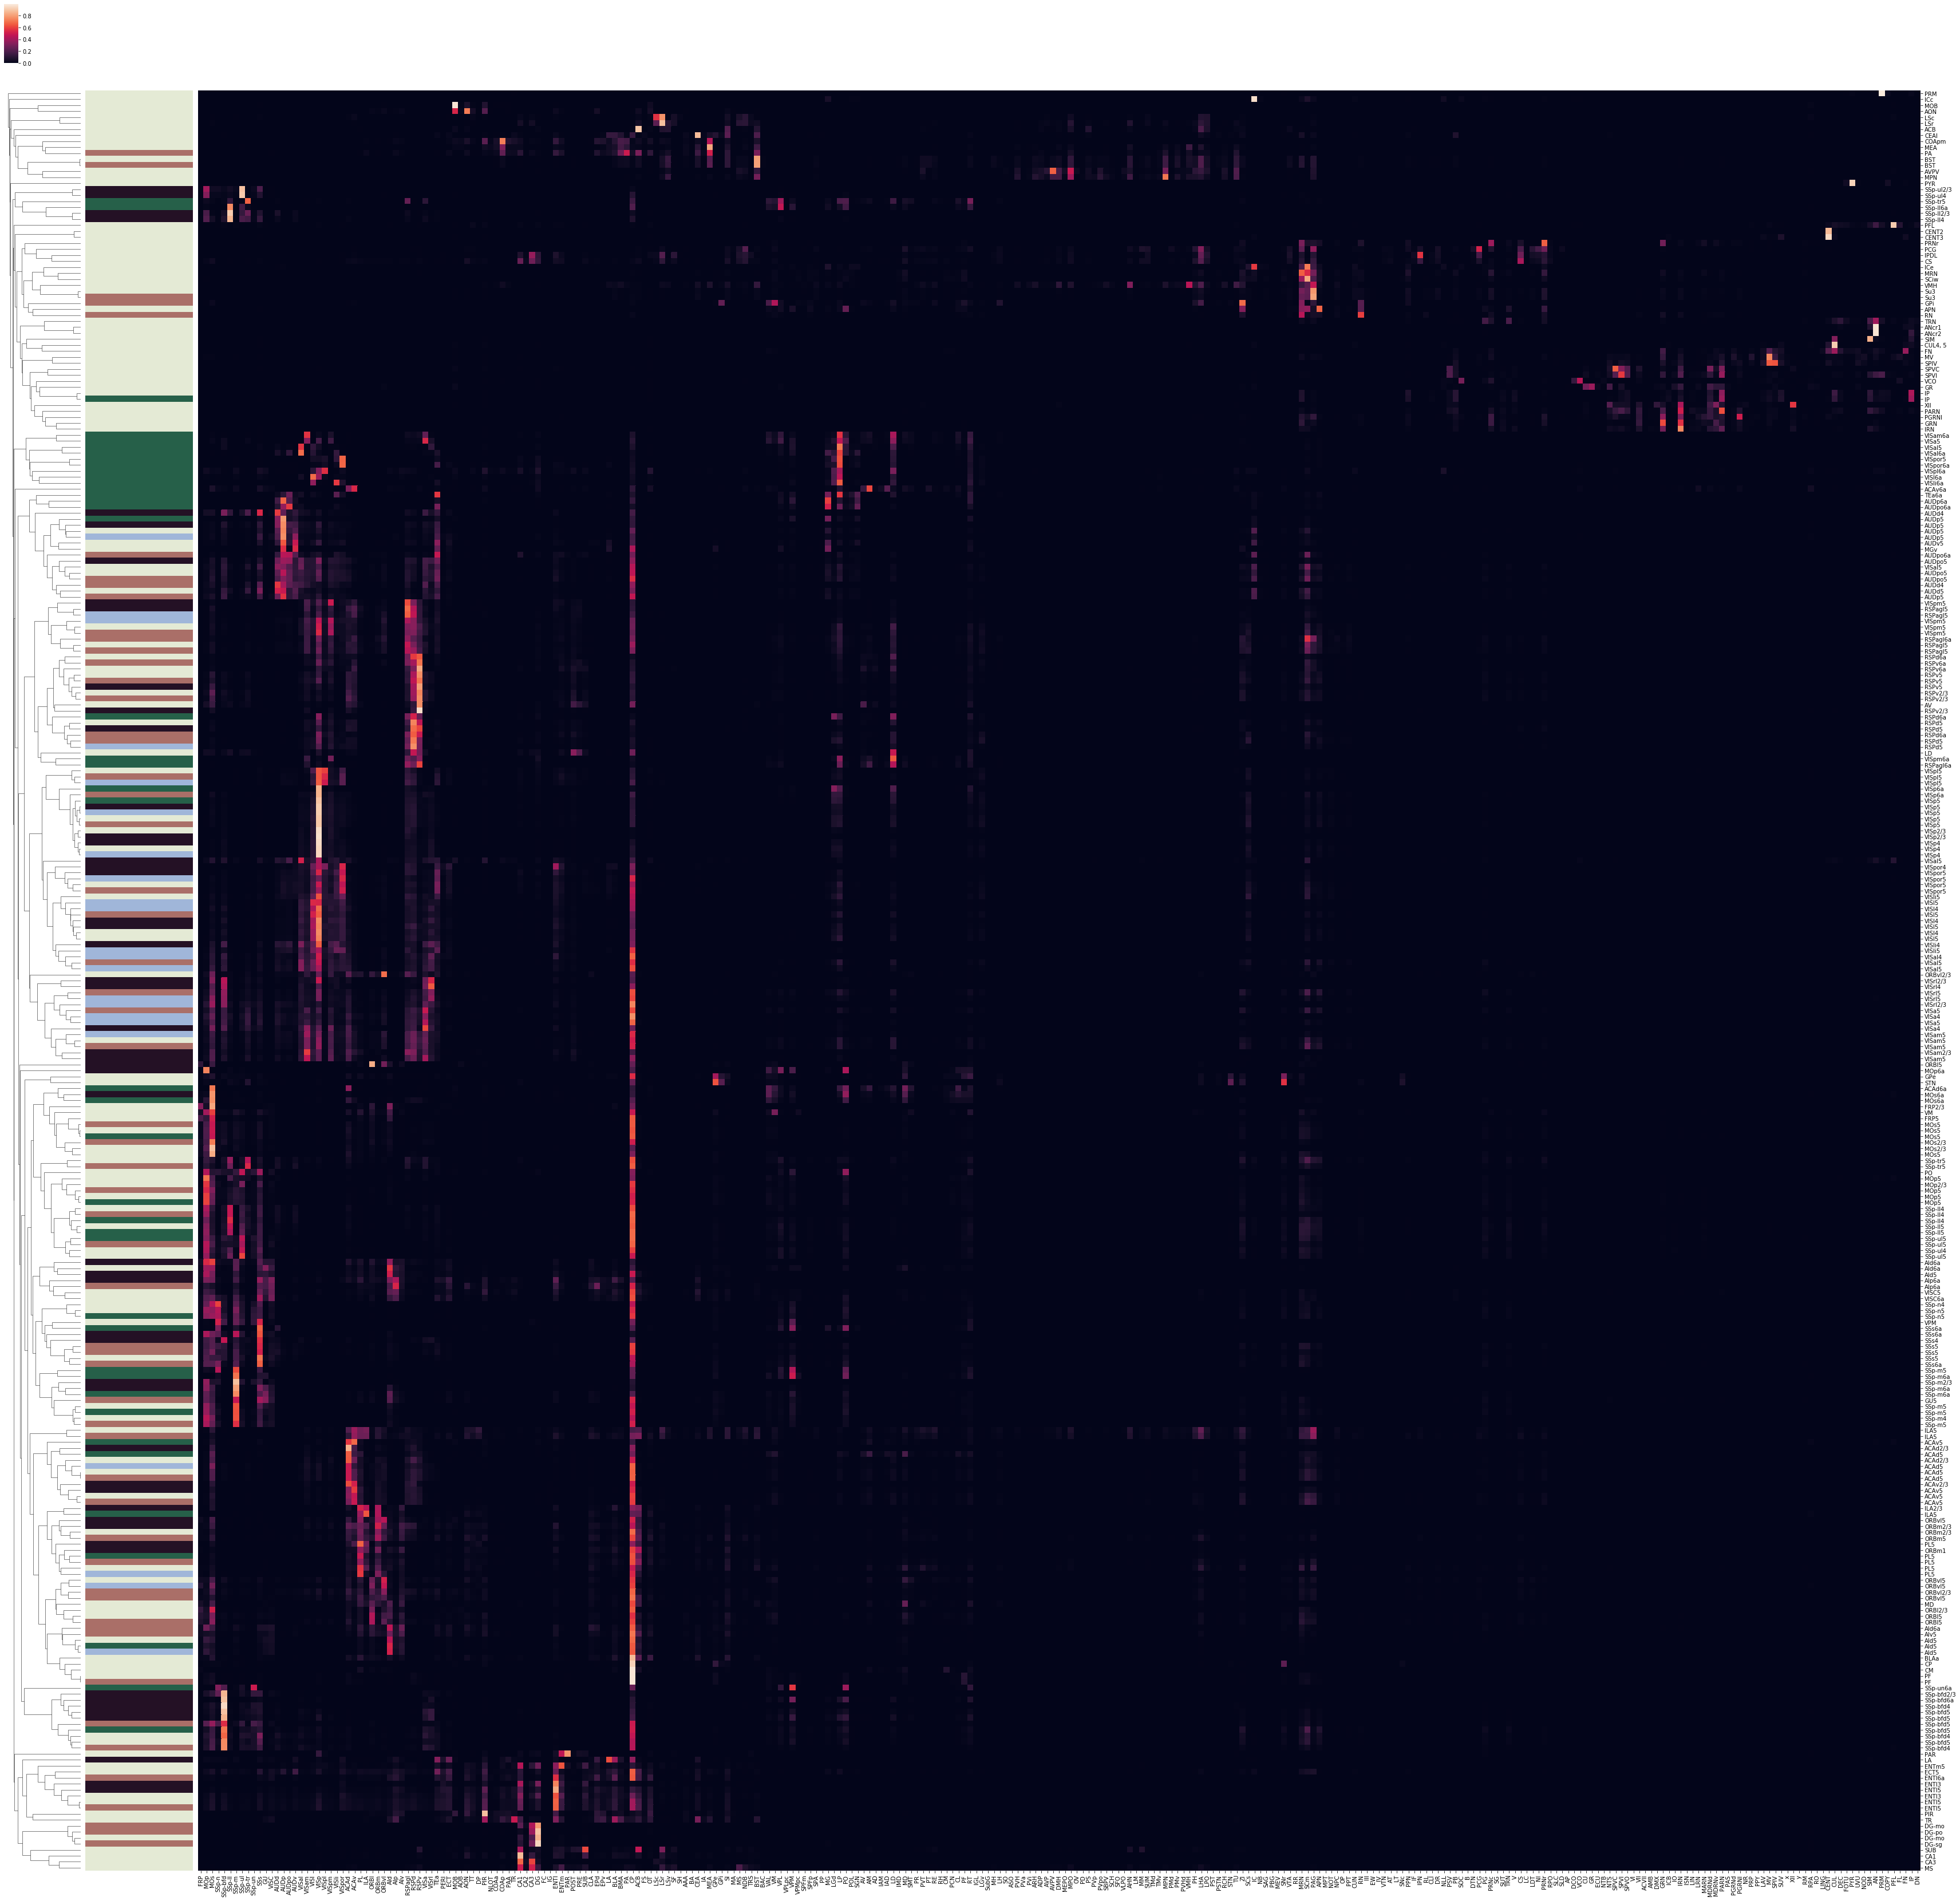

In [51]:
sns.clustermap(comb_data.iloc[gis,:291], row_cluster= True, col_cluster = False, figsize = (60,60),row_colors=np.asarray(major_colors))

In [53]:
from sklearn.metrics import pairwise_distances

In [59]:
dists = pairwise_distances(comb_data.iloc[gis])

In [61]:
types = np.unique(comb_data.iloc[gis].index)

In [98]:
ds = {}
for t in range(len(types)):
    inds = np.where(comb_data.iloc[gis].index == types[t])
    ds[types[t]] = pd.DataFrame(dists[inds][:, inds][:,0,:], 
                                index = ctsss[inds],
                                columns=ctsss[inds])

In [104]:
maxes = np.zeros(len(types))
for t in range(len(types)):
    maxes[t] = np.asarray(ds[types[t]]).max()

In [106]:
top_diff = (-maxes).argsort()

In [107]:
types[top_diff[:10]]

array(['VISal5', 'RSPagl6a', 'VISa5', 'ILA5', 'VISpor5', 'AId6a',
       'SSp-tr5', 'AUDpo6a', 'SSp-m5', 'VISrl2/3'], dtype=object)

In [108]:
types[top_diff[:10]]

array(['VISal5', 'RSPagl6a', 'VISa5', 'ILA5', 'VISpor5', 'AId6a',
       'SSp-tr5', 'AUDpo6a', 'SSp-m5', 'VISrl2/3'], dtype=object)

In [114]:
subdata  = comb_data.loc['VISal5']
subdata.index = ds['VISal5'].index

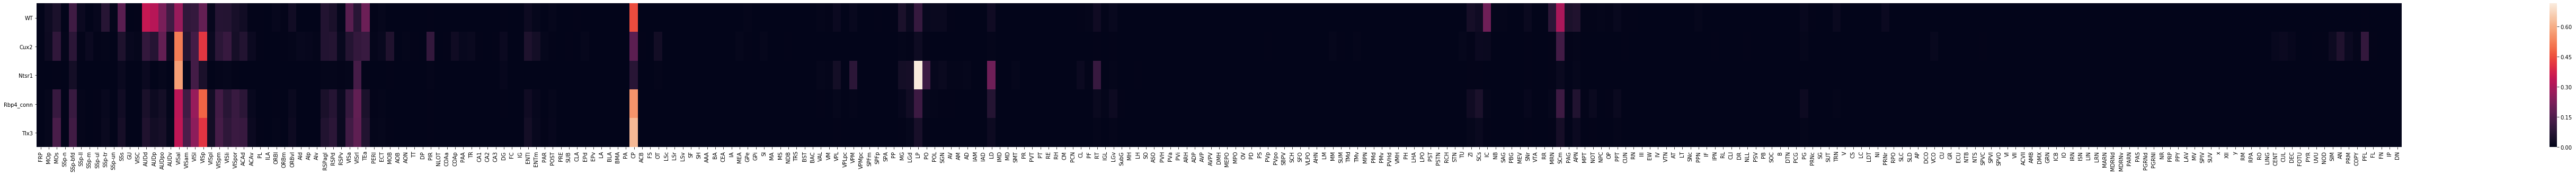

In [121]:
fig ,ax = plt.subplots(figsize= (100,5))
sns.heatmap(subdata.iloc[:,:291])

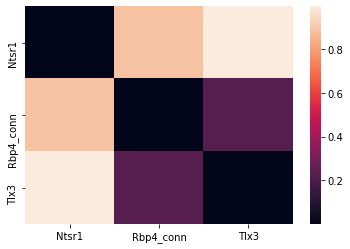

In [111]:
sns.heatmap(ds['VISa5'])

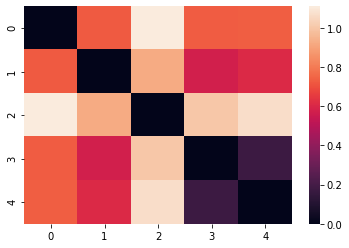

In [92]:
sns.heatmap(ds['VISal5'])

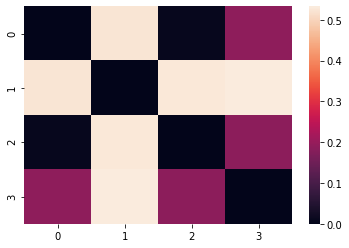

In [81]:
sns.heatmap(ds['ACAd5'])

In [ ]:
2+2

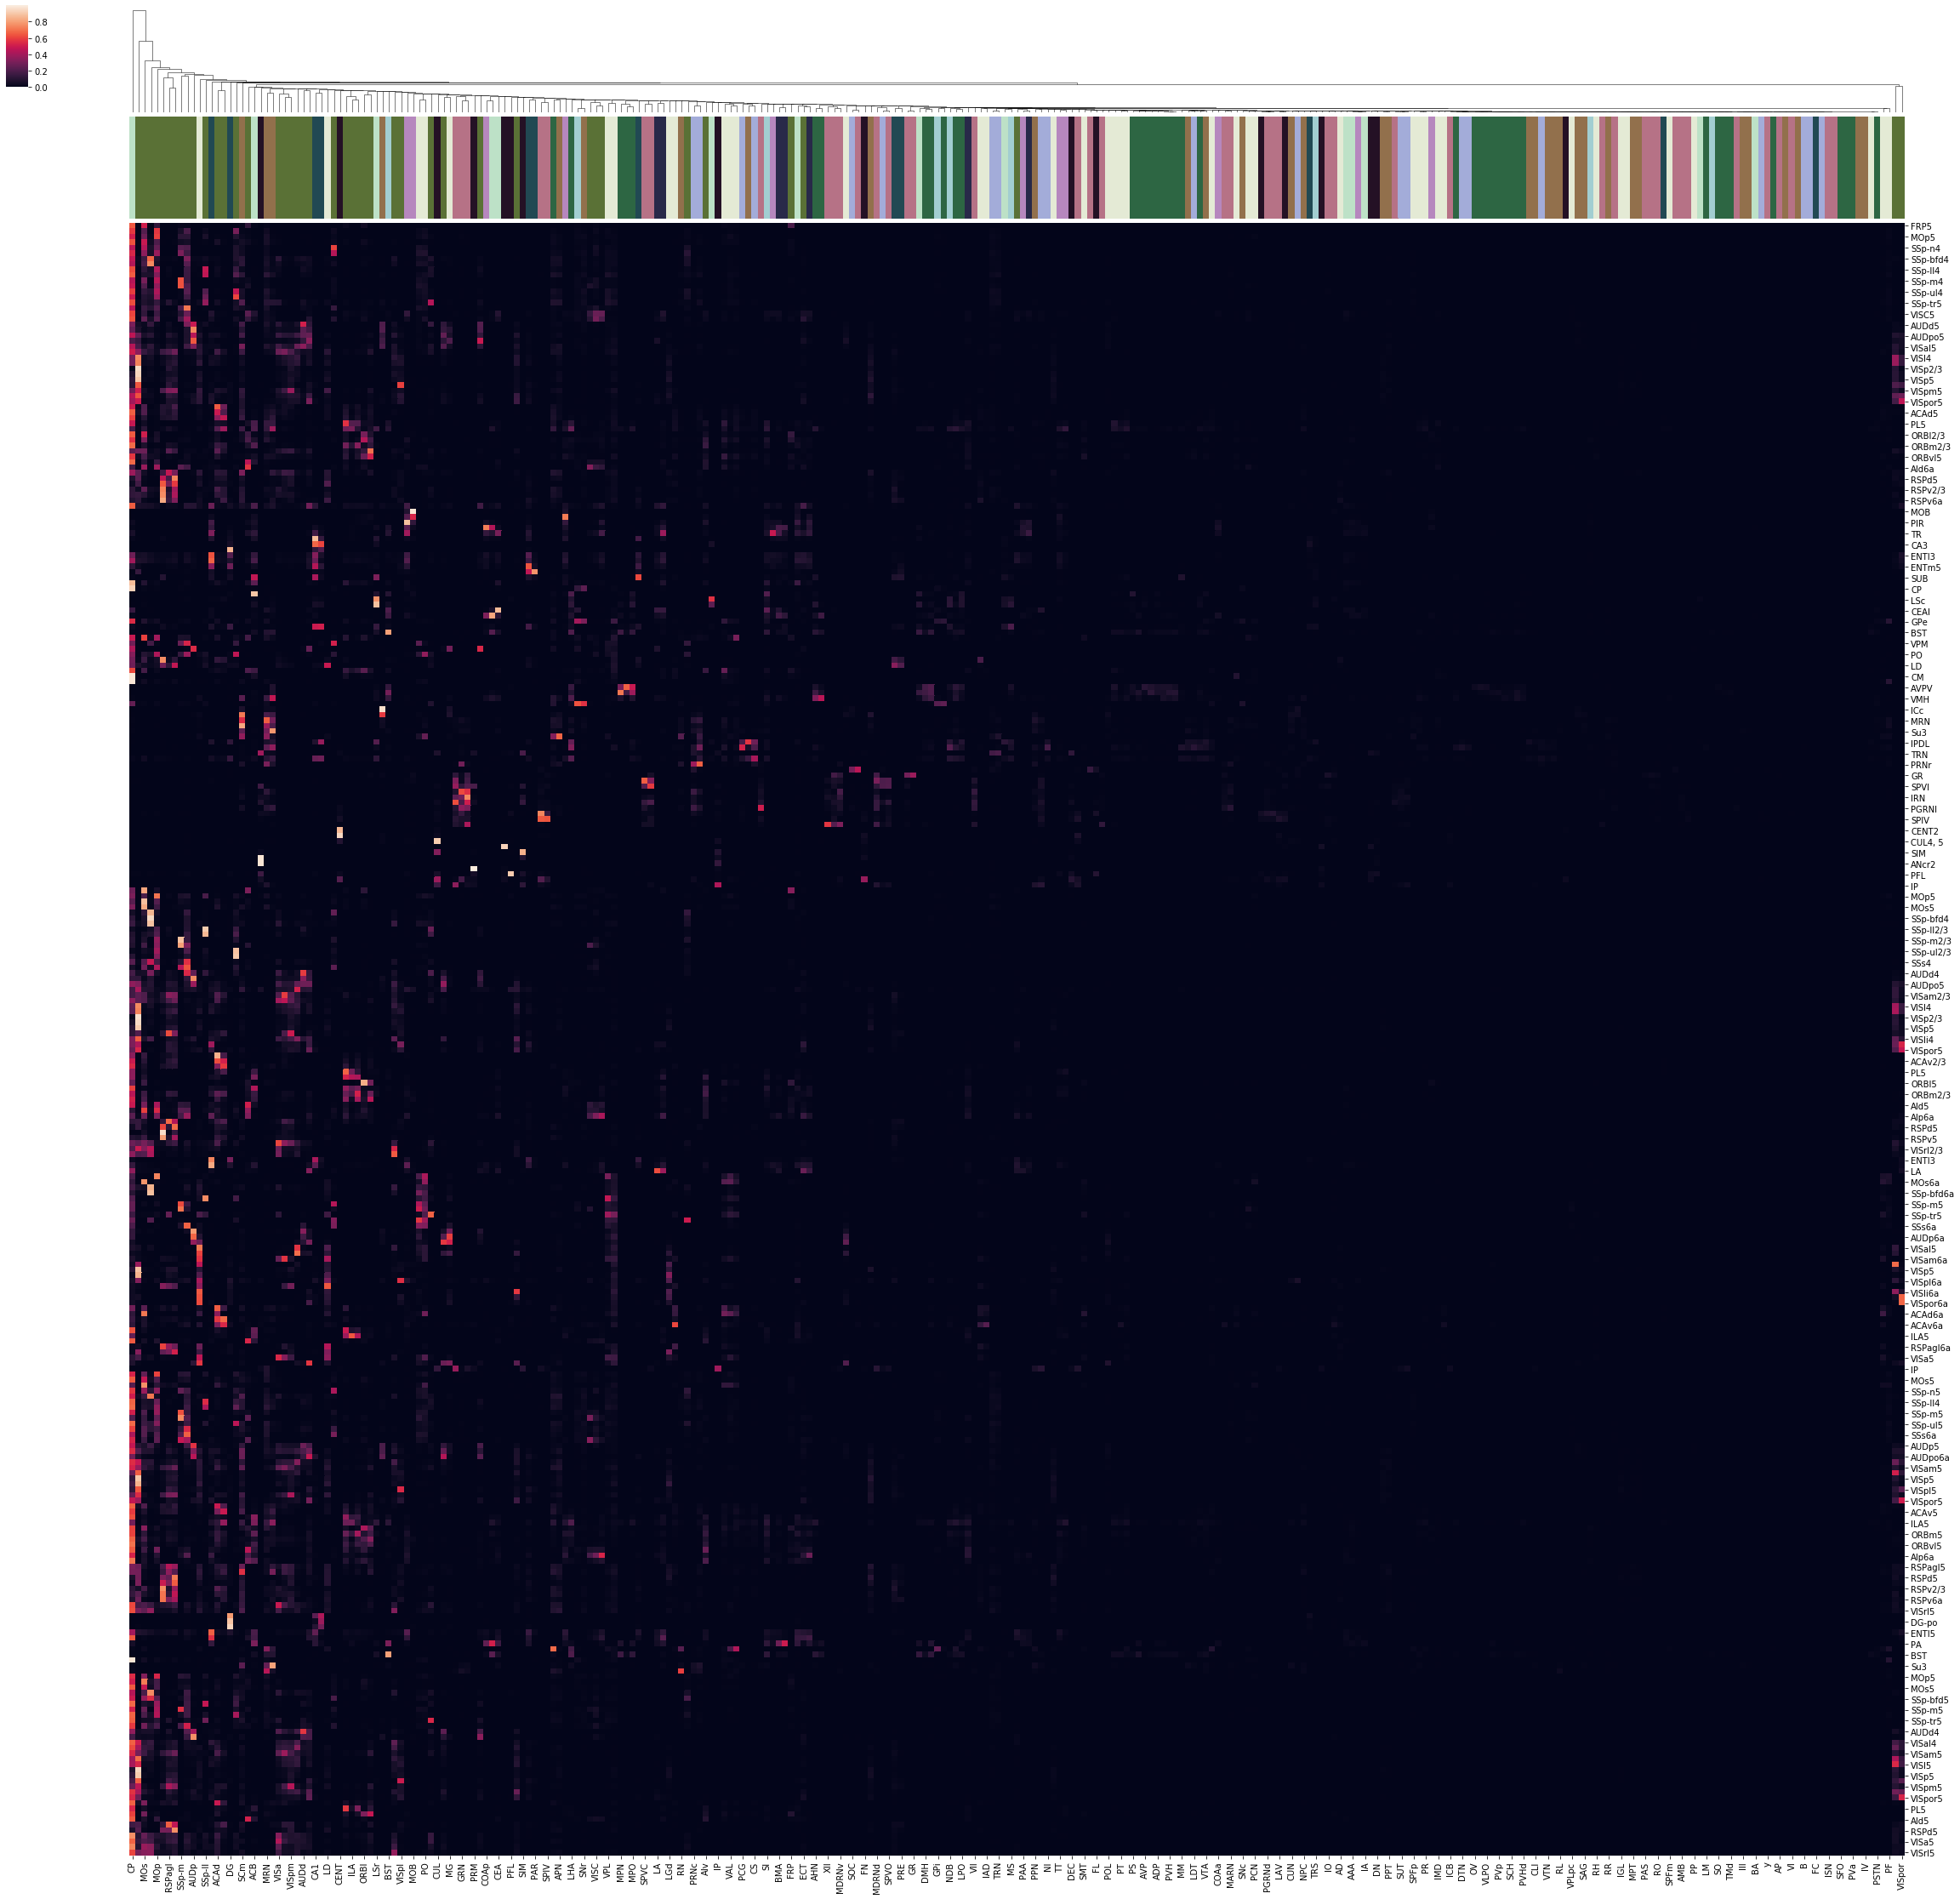

In [142]:
sns.clustermap(comb_data.iloc[gis,:291], row_cluster= False, col_cluster = True, figsize = (40,40),col_colors=np.asarray(major_colors))

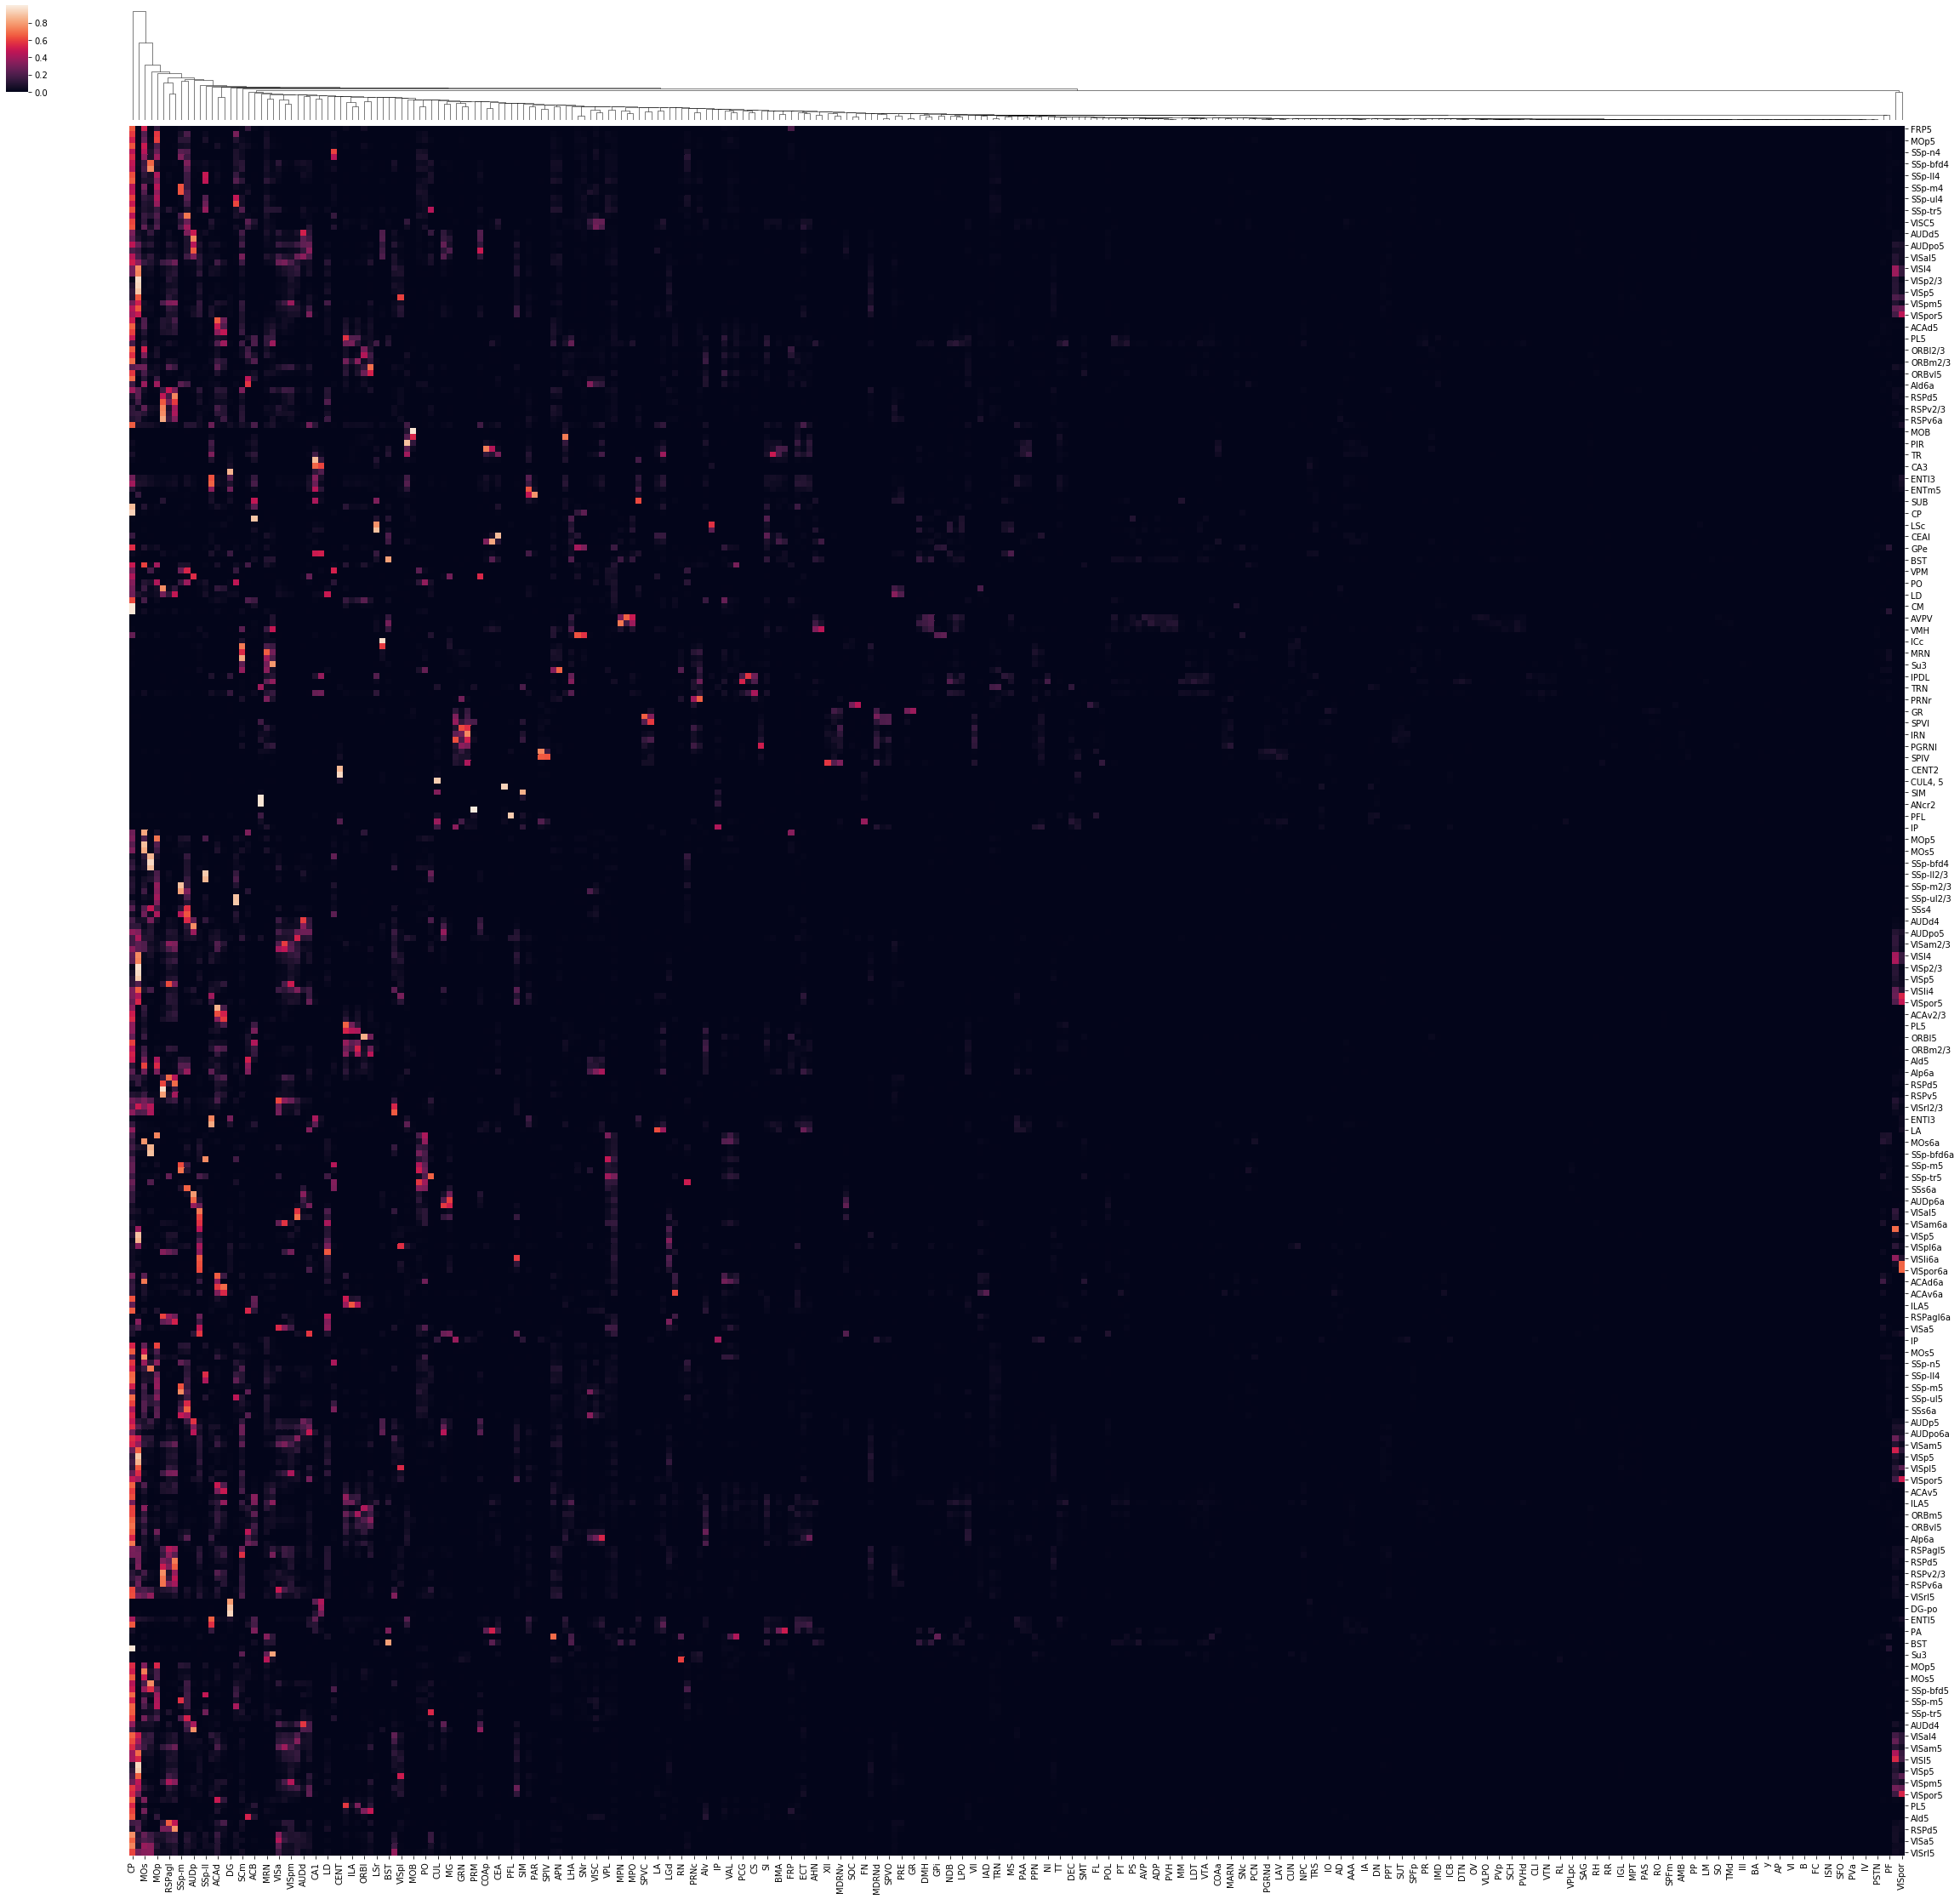

In [134]:
sns.clustermap(comb_data.iloc[gis,:291], row_cluster= False, col_cluster = True, figsize = (40,40))

In [135]:
sns.clustermap(comb_data.iloc[gis,:291], row_cluster= False, col_cluster = True, figsize = (40,40),col_colors=major_colors)

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 2880x2880 with 0 Axes>

ValueError: The condensed distance matrix must contain only finite values.

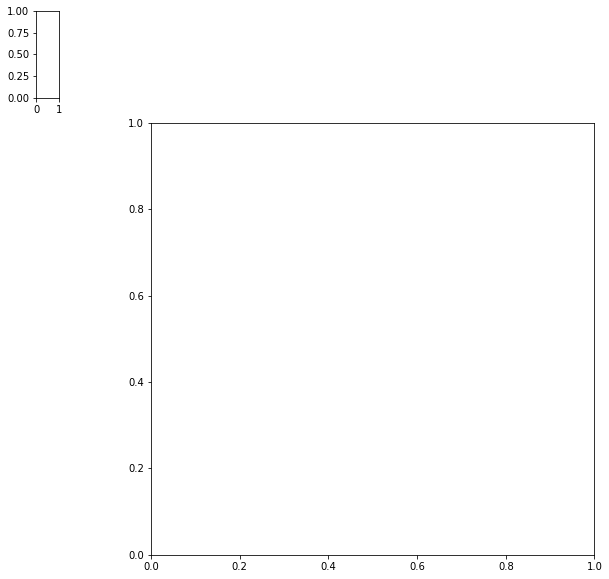

In [122]:
sns.clustermap(comb_data)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


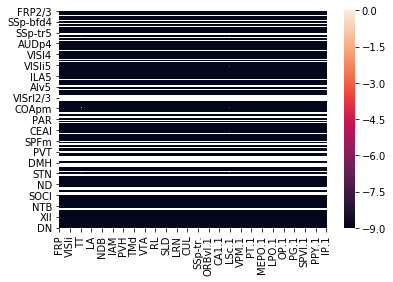

In [30]:
tp = np.log(wt_conn)
#tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0.)#, ax= axes[0,4], cbar = False)


In [38]:
tp = np.log(wt_conn)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [45]:
tp2 = np.log(Ntsr1_conn)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [42]:
ind = np.asarray(np.where(tp < -9)).transpose()

In [43]:
for i in range(ind.shape[0]):
    tp.iloc[ind[i][0],ind[i][1]] = -9

In [46]:
ind2 = np.asarray(np.where(tp2 < -9)).transpose()

In [47]:
for i in range(ind2.shape[0]):
    tp2.iloc[ind2[i][0],ind2[i][1]] = -9

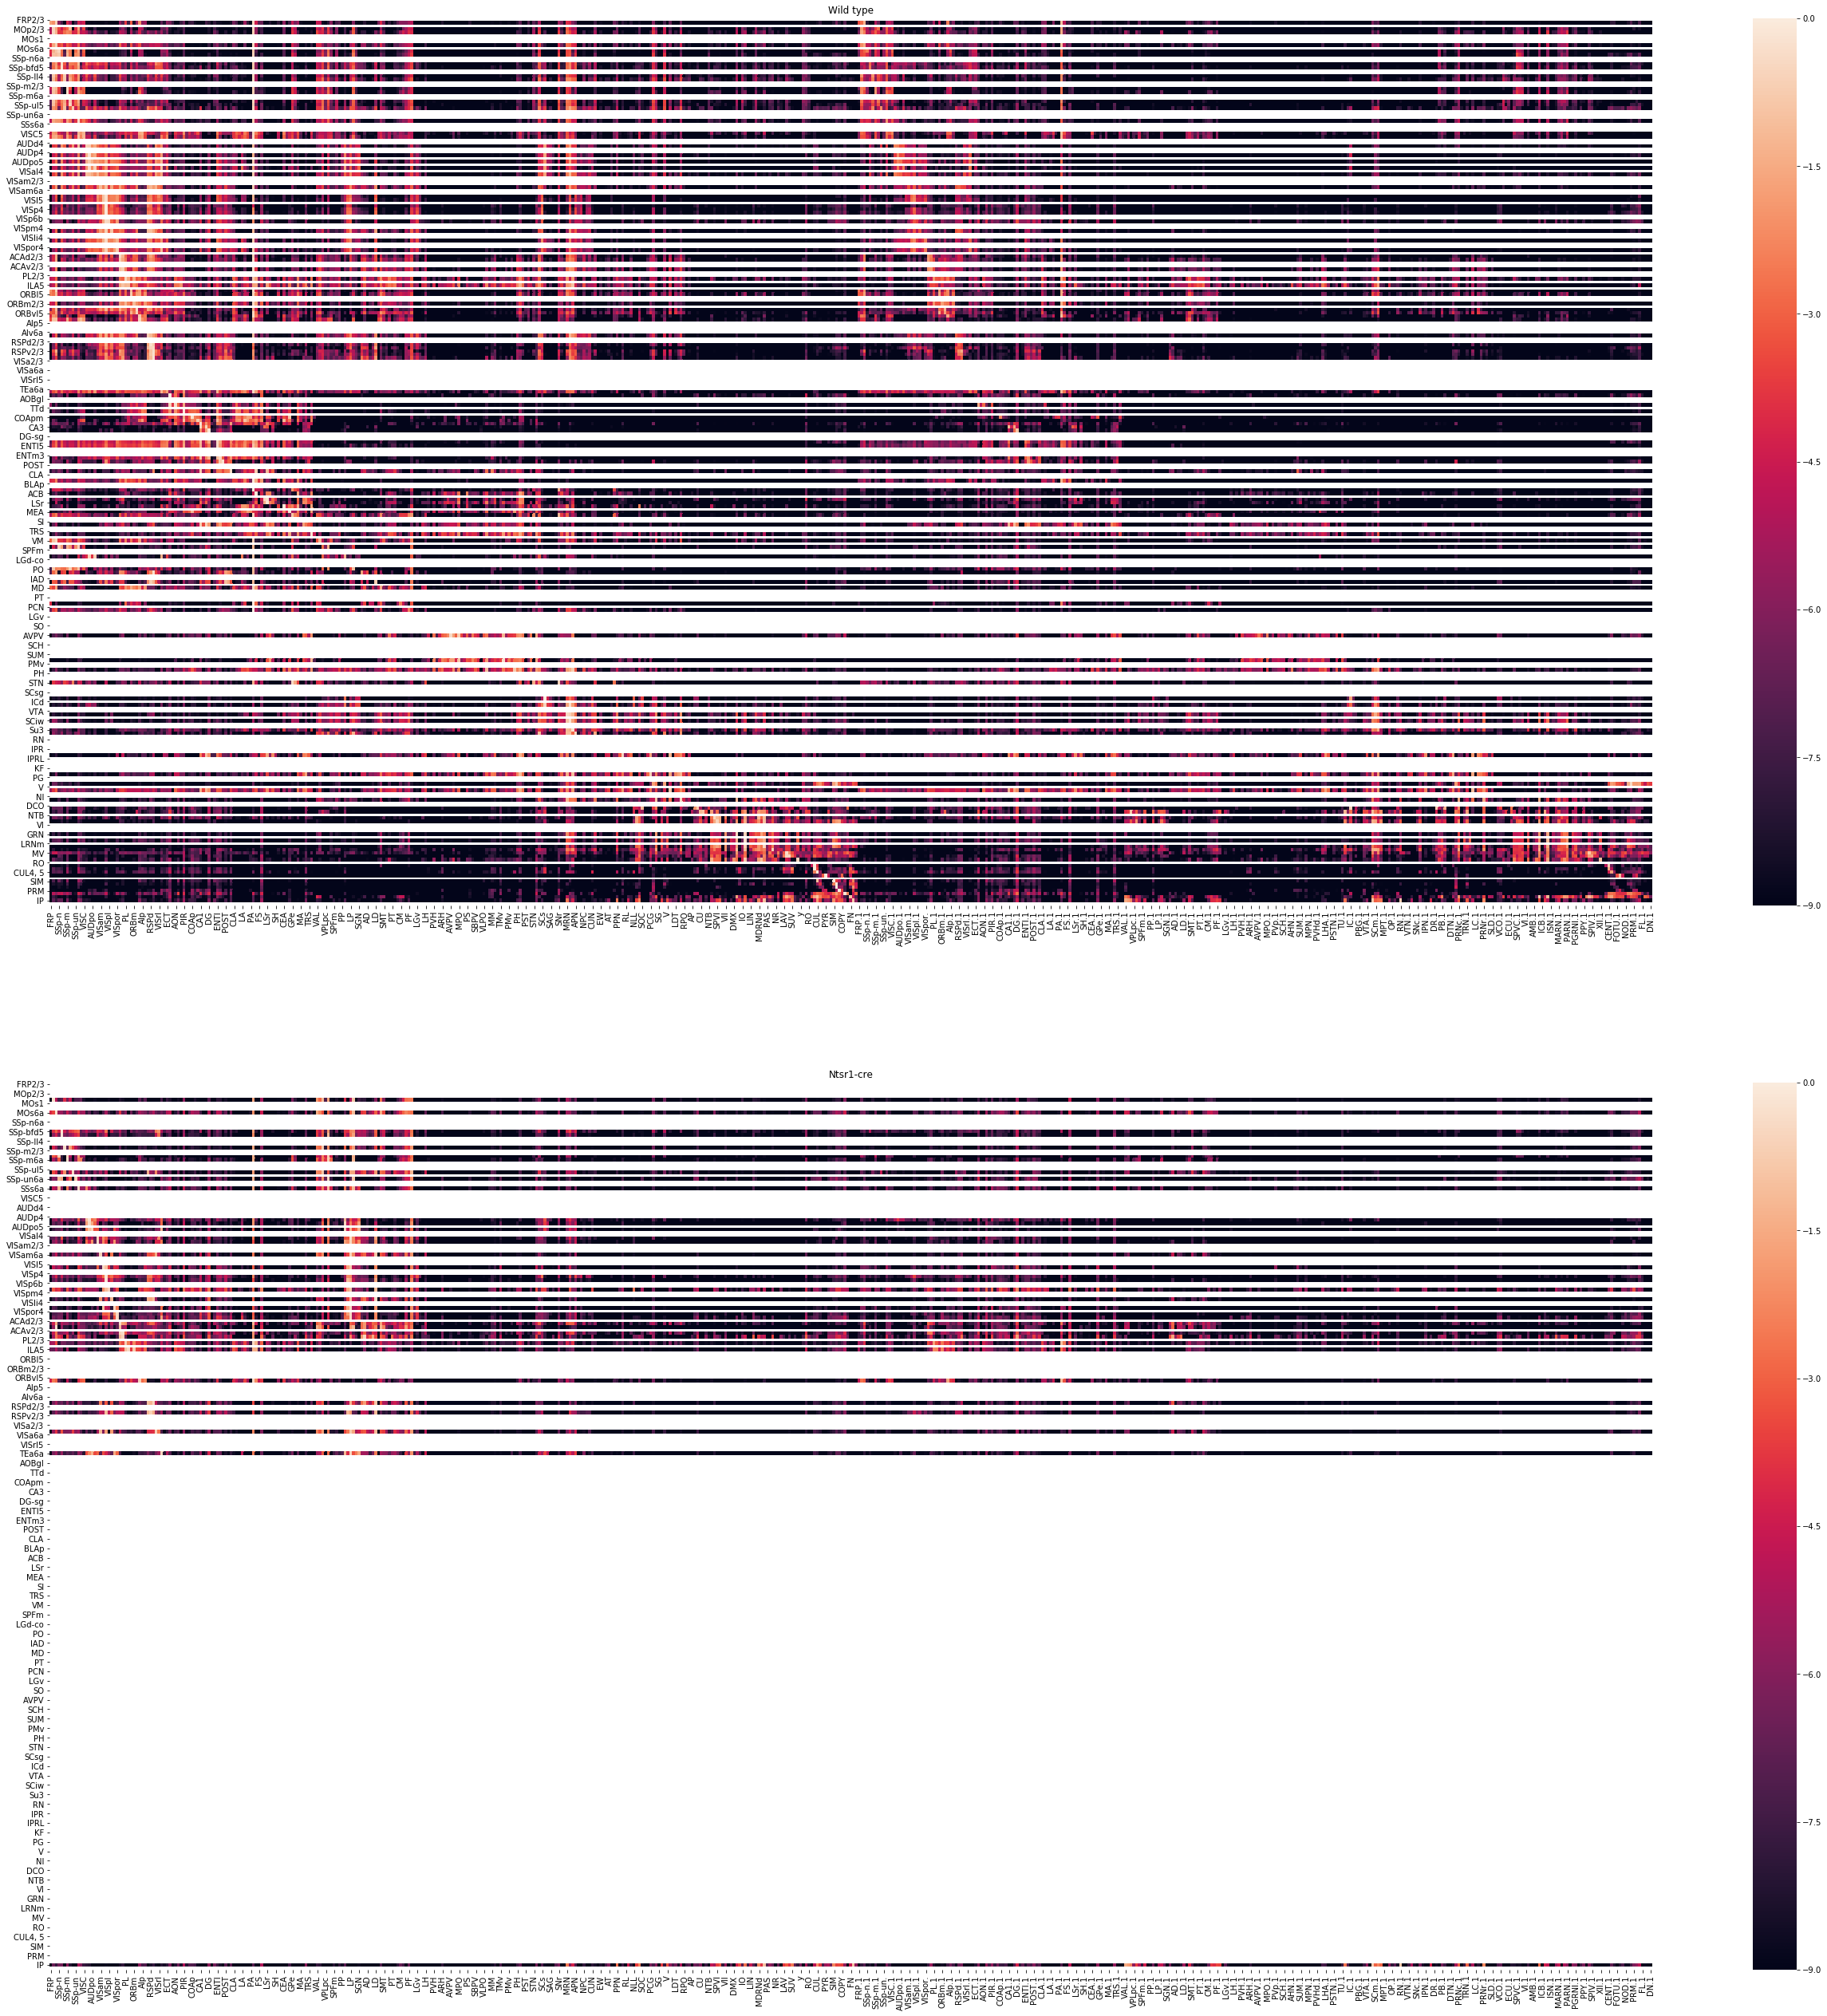

In [53]:
fig, axes = plt.subplots(2, figsize = (45,45))
sns.heatmap(tp, vmin = -9, vmax= 0., ax = axes[0], annot_kws={"size": 4})#, ax= axes[0,4], cbar = False)
sns.heatmap(tp2, vmin = -9, vmax= 0., ax = axes[1], annot_kws={"size": 4})
axes[0].set_title('Wild type')
axes[1].set_title('Ntsr1-cre')
plt.savefig('/Users/samsonkoelle/Ntsr1wtcompare')

array([  1,   3,   4,   8,  10,  11,  14,  15,  18,  19,  22,  23,  26,
        27,  28,  32,  36,  37,  40,  43,  45,  47,  49,  53,  56,  57,
        59,  60,  61,  64,  67,  70,  73,  75,  76,  79,  82,  84,  86,
        87,  90,  92,  93,  94,  95, 100, 103, 104, 105, 106, 107, 118,
       119, 122, 124, 126, 127, 128, 129, 130, 134, 135, 139, 140, 143,
       146, 149, 150, 152, 153, 154, 156, 157, 160, 163, 165, 167, 170,
       174, 175, 178, 180, 185, 187, 195, 203, 206, 210, 215, 217, 220,
       222, 225, 226, 233, 239, 242, 244, 247, 250, 251, 253, 254, 258,
       260, 262, 263, 264, 265, 266, 268, 269, 270, 271, 273, 274, 275,
       276, 277, 278, 279])

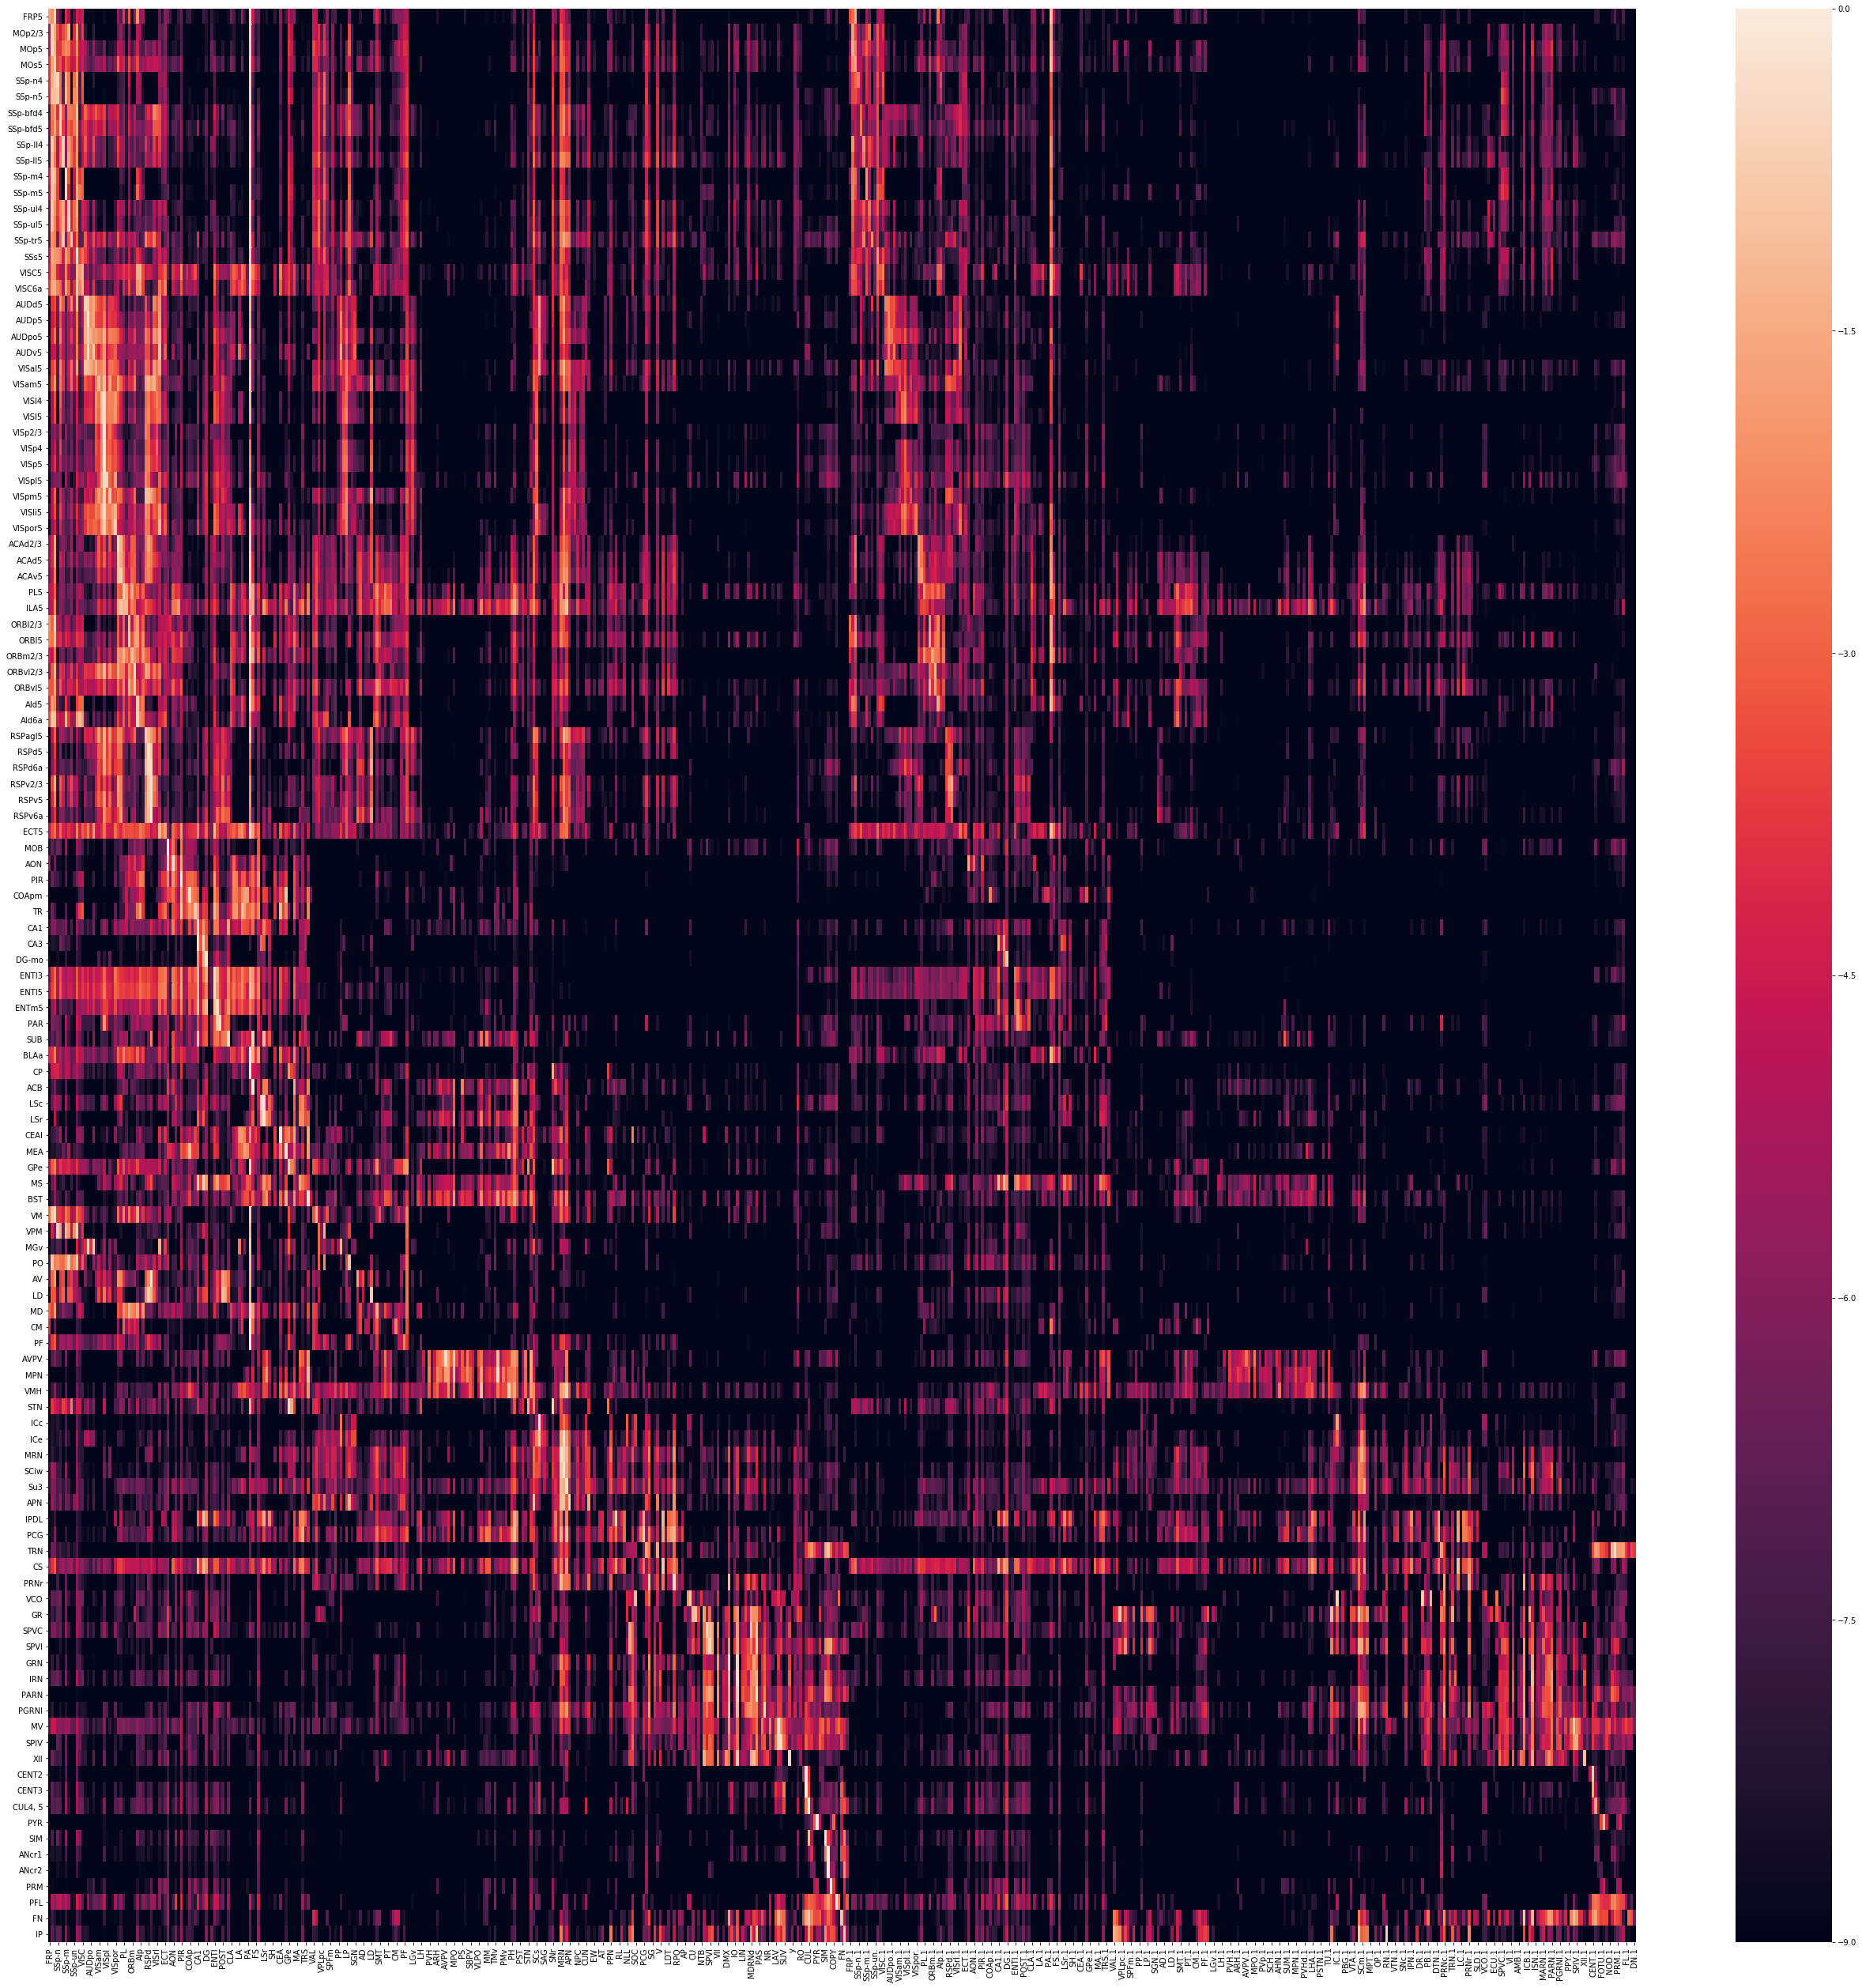

In [58]:
fig, axes = plt.subplots(figsize = (45,45))

sns.heatmap(tp.iloc[np.where(np.sum(tp, axis = 1) != 0.)[0]], vmin = -9, vmax= 0., annot_kws={"size": 4})#, ax= axes[0,4], cbar = False)
plt.savefig('/Users/samsonkoelle/wtonly')

In [59]:
wt_conn

FRP       MOp       MOs     SSp-n   SSp-bfd        SSp-ll  \
FRP2/3       NaN       NaN       NaN       NaN       NaN           NaN   
FRP5    0.189776  0.128179  0.513660  0.002495  0.000663  1.257840e-04   
FRP6a        NaN       NaN       NaN       NaN       NaN           NaN   
MOp2/3  0.005991  0.578971  0.219822  0.032771  0.010587  3.063143e-02   
MOp5    0.007019  0.597349  0.272277  0.021887  0.020701  6.635648e-02   
...          ...       ...       ...       ...       ...           ...   
PRM     0.000000  0.000152  0.000080  0.000072  0.000043  0.000000e+00   
PFL     0.000013  0.007338  0.002775  0.007707  0.010487  3.404445e-03   
FN      0.000000  0.000512  0.000261  0.000095  0.000166  4.726471e-09   
IP      0.000068  0.001129  0.000371  0.001163  0.001245  7.805668e-05   
DN           NaN       NaN       NaN       NaN       NaN           NaN   

           SSp-m    SSp-ul        SSp-tr        SSp-un  ...     NOD.1  \
FRP2/3       NaN       NaN           NaN           NaN  ...       NaN   
FRP5    0.016080  0.005566  6.659672e-05  6.427689e-04  ...  0.000021   
FRP6a        NaN       NaN           NaN           NaN  ...       NaN   
MOp2/3  0.059254  0.302035  1.024595e-04  1.802238e-02  ...  0.000031   
MOp5    0.111273  0.088538  1.292033e-02  1.769790e-02  ...  0.000017   
...          ...       ...           ...           ...  ...       ...   
PRM     0.000134  0.000004  0.000000e+00  5.577093e-06  ...  0.000000   
PFL     0.007828  0.002710  1.540145e-04  2.284307e-04  ...  0.020104   
FN      0.000337  0.000027  3.489020e-08  2.008037e-08  ...  0.000381   
IP      0.002079  0.000244  4.703579e-05  4.342121e-05  ...  0.000117   
DN           NaN       NaN           NaN           NaN  ...       NaN   

           SIM.1      AN.1     PRM.1    COPY.1     PFL.1      FL.1  \
FRP2/3       NaN       NaN       NaN       NaN       NaN       NaN   
FRP5    0.000264  0.000836  0.000217  0.000158  0.000753  0.000105   
FRP6a        NaN       NaN       NaN       NaN       NaN       NaN   
MOp2/3  0.000042  0.000124  0.000332  0.000048  0.000213  0.000013   
MOp5    0.000082  0.000091  0.000070  0.000061  0.000089  0.000008   
...          ...       ...       ...       ...       ...       ...   
PRM     0.000021  0.000179  0.004398  0.004770  0.000044  0.000000   
PFL     0.087310  0.107336  0.047995  0.033759  0.031179  0.002905   
FN      0.011068  0.043106  0.030363  0.018532  0.000540  0.000070   
IP      0.000153  0.000517  0.001095  0.002724  0.007961  0.000061   
DN           NaN       NaN       NaN       NaN       NaN       NaN   

                FN.1      IP.1          DN.1  
FRP2/3           NaN       NaN           NaN  
FRP5    2.393211e-06  0.000002  3.611911e-08  
FRP6a            NaN       NaN           NaN  
MOp2/3  5.919232e-08  0.000009  0.000000e+00  
MOp5    5.178746e-06  0.000025  5.420503e-06  
...              ...       ...           ...  
PRM     0.000000e+00  0.000000  0.000000e+00  
PFL     3.246019e-04  0.001380  1.456759e-04  
FN      5.254120e-02  0.037772  1.690367e-03  
IP      1.998830e-04  0.000115  1.250950e-04  
DN               NaN       NaN           NaN  

[281 rows x 577 columns]